In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from models.utils import build_models, train_models, get_final_models_dict, plot_lmls, get_metrics

import os
import pathlib as pl
from gpflow.utilities import read_values
import pickle
import sys

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# make sure tensorflow doesn't use too many cpus
tf.config.threading.set_intra_op_parallelism_threads(5)
tf.config.threading.set_inter_op_parallelism_threads(5)

2023-05-24 11:35:10.006691: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# define variables
sys_args = [0, 3, 1, 2] #sys.argv[:]

n_new_points = int(sys_args[1])  # number of points on new surfaces
seed = int(sys_args[2])  # seed
relation_type = int(sys_args[3])  # type of relationship between surfaces

if relation_type == 1:
    surface_type = 'unrelated'
    from models.test_functions import TestFunUncorrelated as TestFun
elif relation_type == 2:
    surface_type = 'linear_relation'
    from models.test_functions import TestFunLinearCorrelation as TestFun
elif relation_type == 3:
    surface_type = 'non-linear_relation'
    from models.test_functions import TestFunNonLinearCorrelation as TestFun

else:
    raise ValueError('relation_type must be in {1, 2, 3}')

set_seed = True

if set_seed:
    np.random.seed(seed)
    tf.random.set_seed(seed)
else:
    seed = None

plot_figs = True
train_inducing = True  # whether we train the inducing points or not

model_names = ['lmc', 'mo_indi', 'lvmogp', 'avg'] # 'lvmogp',
n_new_funs = 10
data_type_name = f'two_observed_{n_new_funs}_new'
n_fun = 2 + n_new_funs
total_train = 10 * 2 + 3 * n_new_points  # total number of training points
n_points = [10] * 2 + [n_new_points] * n_new_funs  # number of points on each surface

domain = [0, 2]
latent_dims = 2
latent_dims_lvmogp = 2
observed_dims = 1
max_points = 60
same_points = False

noise = 0.05
n_grid_points = 100
continuous_dims = ['x1', 'x2'][:observed_dims]
lengthscales_x = [0.3, 0.3]

plot_path = pl.Path.home() / f'Transfer_Learning_GP_Results/plots/'

TypeError: list indices must be integers or slices, not tuple

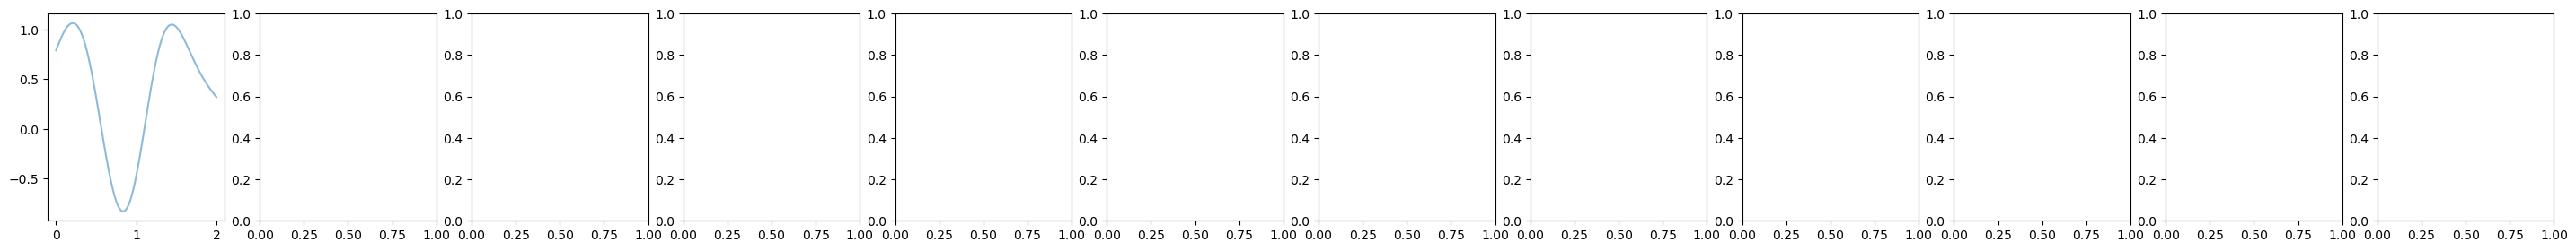

In [3]:
# make test function

test_fun = TestFun(domain, seed, n_fun, observed_dims, latent_dims, max_points, noise, n_grid_points, same_points,
                   lengthscales_x)

data_X, fun_nos, data_y = test_fun.create_data(n_points=n_points)

# have option to plot and save test function

if plot_figs:
    test_fun.plot_data_seperate_plots()
    plt.savefig(plot_path / f'data_seperate_{surface_type}_{data_type_name}_{n_new_points}_points_seed_{seed}.png')
    plt.close()

In [4]:
models_dict = build_models(model_names, data_X, data_y, fun_nos, n_fun, observed_dims, latent_dims, latent_dims_lvmogp,
                           domain, n_restarts=1)

successful build model lmc, restart 0, init_type random_W_and_k
successful build model lmc, restart 0, init_type random_W_and_k_0
successful build model lmc, restart 0, init_type random_W_and_k_1
successful build model mo_indi, restart 0, init_type random restart 1
successful build model mo_indi, restart 0, init_type random restart 2
successful build model mo_indi, restart 0, init_type random restart 3
successful build model lvmogp, restart 0, init_type random
successful build model lvmogp, restart 0, init_type mo_pca
successful build model lvmogp, restart 0, init_type gpy
successful build model avg, restart 0, init_type random restart 1
successful build model avg, restart 0, init_type random restart 2
successful build model avg, restart 0, init_type random restart 3


/home/ruby/anaconda3/envs/tlgps/lib/python3.9/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


In [5]:
models_dict, lmls = train_models(models_dict)

successful train lmc, restart 0, init_type random_W_and_k
successful train lmc, restart 0, init_type random_W_and_k_0
successful train lmc, restart 0, init_type random_W_and_k_1
successful train mo_indi, restart 0, init_type random restart 1
successful train mo_indi, restart 0, init_type random restart 2
successful train mo_indi, restart 0, init_type random restart 3
successful train lvmogp, restart 0, init_type random
successful train lvmogp, restart 0, init_type mo_pca
successful train lvmogp, restart 0, init_type gpy
successful train avg, restart 0, init_type random restart 1
successful train avg, restart 0, init_type random restart 2
successful train avg, restart 0, init_type random restart 3


In [6]:
final_models_dict = get_final_models_dict(models_dict)

In [7]:
from gpflow.base import _cast_to_dtype
from gpflow.config import default_float
n_points = 100
x_new = np.linspace(domain[0], domain[1], n_points).reshape(n_points, 1)
fun_nos = np.hstack([[fun_no] * n_points for fun_no in range(n_fun)]).reshape(n_points*n_fun, observed_dims)
test = np.tile(x_new.flatten(), n_fun)
x_new_lmc = np.hstack([np.tile(x_new.flatten(), n_fun).reshape(n_points*n_fun, observed_dims), fun_nos])

if 'lvmogp' in final_models_dict.keys():
    lvmogp = final_models_dict['lvmogp']

    H_mean_vect = tf.reshape(tf.gather(_cast_to_dtype(lvmogp.H_data_mean, dtype=default_float()),
                                       _cast_to_dtype(fun_nos, dtype=tf.int64)),
                             [len(np.tile(x_new.flatten(), n_fun)), lvmogp.H_data_mean.numpy().shape[1]])
    H_var_vect = tf.reshape(tf.gather(_cast_to_dtype(lvmogp.H_data_var, dtype=default_float()),
                                      _cast_to_dtype(fun_nos, dtype=tf.int64)),
                            [len(np.tile(x_new.flatten(), n_fun)), lvmogp.H_data_mean.numpy().shape[1]])

    Xnew_mean = tf.concat([tf.convert_to_tensor(np.tile(x_new.flatten(), n_fun).reshape(n_points*n_fun, 1), default_float()), H_mean_vect], axis=1)
    Xnew_var = tf.concat([tf.zeros(np.tile(x_new.flatten(), n_fun).reshape(n_points*n_fun, 1).shape, dtype=default_float()), H_var_vect], axis=1)
    x_new_lvmogp = [Xnew_mean, Xnew_var]
else:
    x_new_lvmogp = None

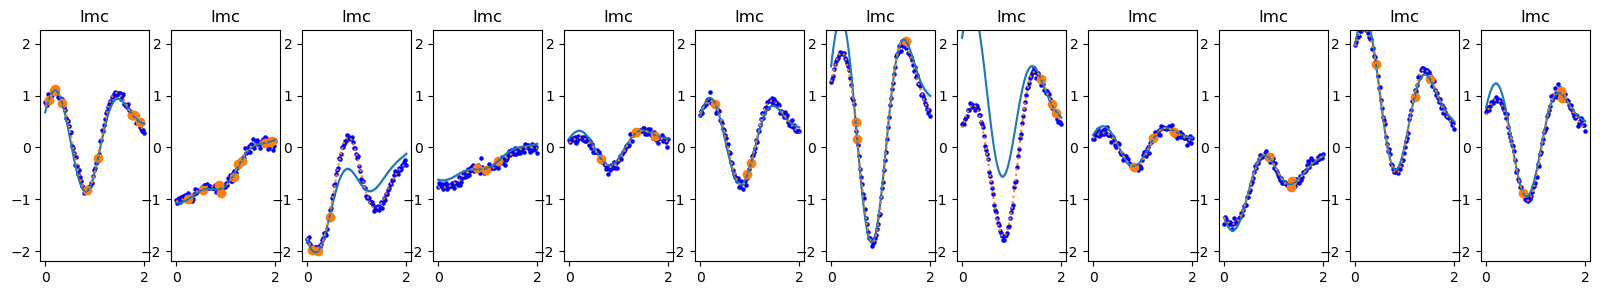

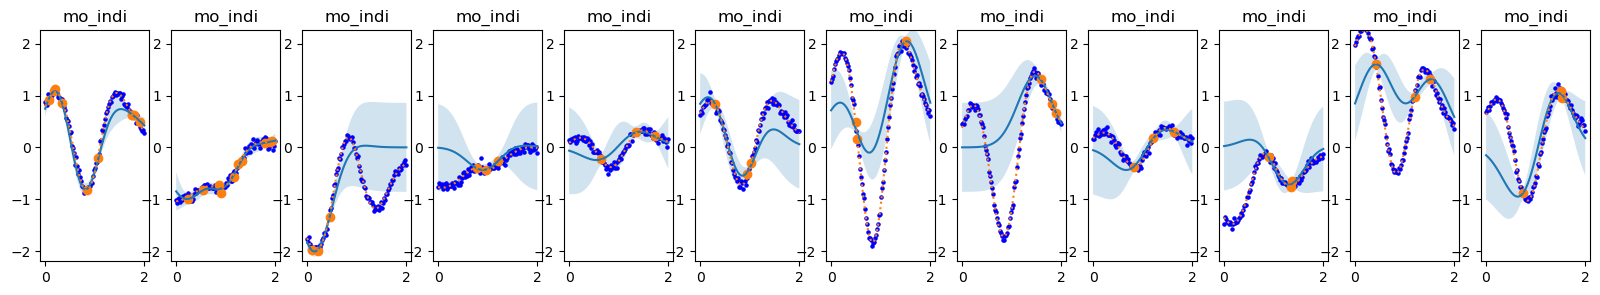

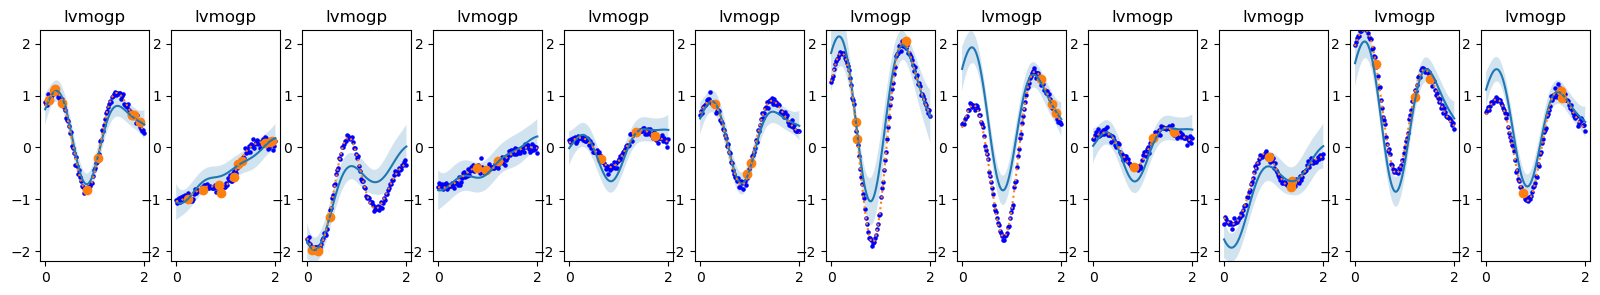

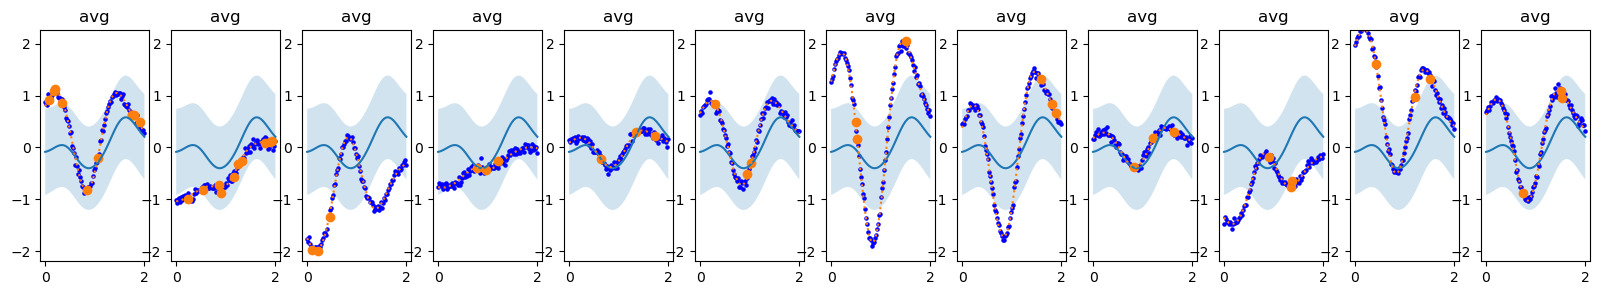

In [15]:
from models.utils import get_nlpd, get_abs_error
import pandas as pd

model_x_news = {'avg': x_new, 'mo_indi': x_new_lmc, 'lmc': x_new_lmc, 'lvmogp': x_new_lvmogp}

# get the true data values at the grid points
ys_new = []
fs_new = []
for fun in test_fun.functions:
    f_new, _ = fun.predict_y(x_new.reshape(100, 1))
    y_new = test_fun.function_with_noise(fun, x_new.reshape(100, 1), test_fun.noise)
    ys_new.append(y_new)
    fs_new.append(f_new)

res_dfs = []
for model_name, model in final_models_dict.items():
    NLPDs = []
    RMSEs = []
    NLPDs_new_only = []
    RMSEs_new_only = []
    x = model_x_news[model_name]
    pred_mu, pred_var = model.predict_y(x)
    # pred_var = pred_var + tf.linalg.diag([model.likelihood.variance.numpy()]*len(tf.linalg.diag_part(pred_var) ))
    fig, axs = plt.subplots(nrows=1, ncols=n_fun, figsize=(20, 3))
    for i, fun_no in enumerate(range(n_fun)):
        if model_name == 'avg':
            idx = range(len(x_new))
        else:
            idx = range(n_points*i, n_points*(i+1))
        mu = pred_mu.numpy()[idx].flatten()
        axs[i].plot(x_new, pred_mu.numpy()[idx].flatten())
        axs[i].fill_between(x_new.flatten(), pred_mu.numpy()[idx].flatten()+ np.sqrt(pred_var.numpy()[idx].flatten()),
                            pred_mu.numpy()[idx].flatten() - np.sqrt(pred_var.numpy()[idx].flatten()), alpha=0.2)
        axs[i].plot(x_new, fs_new[i].numpy(), linestyle=':')
        axs[i].scatter(x_new,ys_new[i].numpy(), s=5, color='blue')
        idx_train = np.where([test_fun.fun_no==fun_no])[1]
        axs[i].scatter(test_fun.X[idx_train], test_fun.y[idx_train])
        axs[i].set_ylim(np.min(data_y)-0.2, np.max(data_y)+0.2)
        axs[i].set_title(model_name)
        sig2 = pred_var.numpy()[idx].flatten()
        nlpds = get_nlpd(mu, sig2,  ys_new[i].numpy().flatten())
        abs_errors = get_abs_error(mu, ys_new[i].numpy().flatten())
        NLPDs.append(nlpds)
        RMSEs.append(abs_errors)
        if fun_no >= (n_fun - n_new_funs):
            # print(fun_no)
            NLPDs_new_only.append(nlpds)
            RMSEs_new_only.append(abs_errors)
    nlpd = np.mean(NLPDs)
    rmse = np.sqrt(np.mean(np.square(RMSEs)))
    nlpd_new_only = np.mean(NLPDs_new_only)
    rmse_new_only = np.sqrt(np.mean(np.square(RMSEs_new_only)))
    row_df = pd.DataFrame(data=[[model_name, nlpd, rmse, nlpd_new_only, rmse_new_only,
                                model.maximum_log_likelihood_objective().numpy()]],
                          columns=['model', 'nlpd', 'rmse', 'nlpd_new_surface', 'rmse_new_surface',  'lml'])
    res_dfs.append(row_df)

results_df = pd.concat(res_dfs)

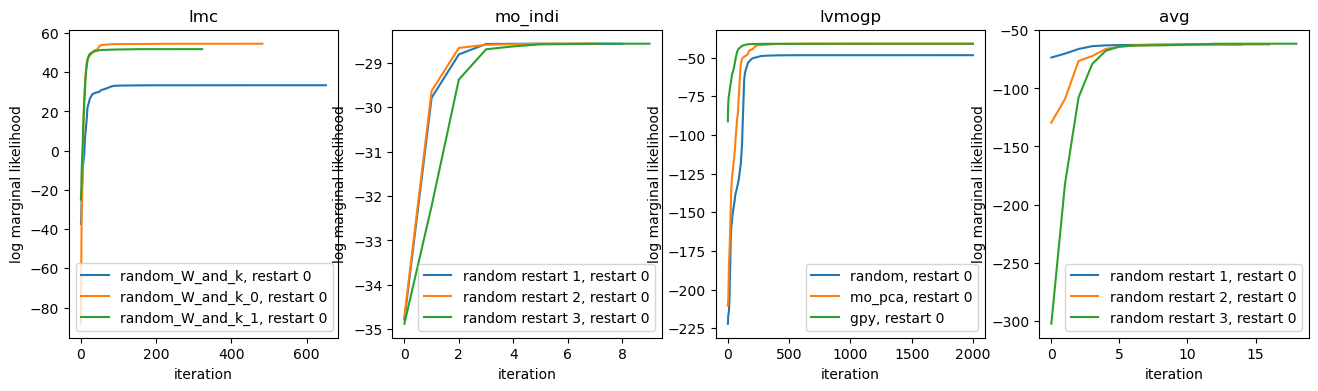

In [16]:
plot_lmls(lmls)

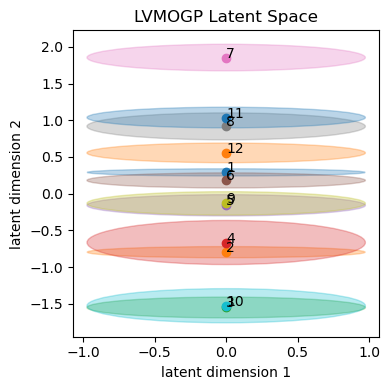

In [17]:
from matplotlib.patches import Ellipse
fig = plt.figure(figsize=(4, 4))
axsH = plt.gca()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] * 3
for i, H_coord in enumerate(final_models_dict['lvmogp'].H_data_mean.numpy()):
    axsH.scatter(H_coord[0],H_coord[1], label=f'{i + 1}', color=colors[i])
    axsH.annotate(f'{i + 1}', (H_coord[0], H_coord[1]))
    axsH.set_title(f"LVMOGP Latent Space")
    axsH.set_xlabel(f'latent dimension 1')
    axsH.set_ylabel(f'latent dimension 2')
    circle1 = Ellipse((H_coord[0], H_coord[1]),
                      1.95 * np.sqrt(final_models_dict['lvmogp'].H_data_var.numpy()[i, 0]),
                      1.95 * np.sqrt(final_models_dict['lvmogp'].H_data_var.numpy()[i, 1])
                      , color=colors[i], alpha=0.3, zorder=0)
    axsH.add_patch(circle1)
plt.tight_layout()

In [18]:
print(results_df)

     model       nlpd      rmse  nlpd_new_surface  rmse_new_surface        lml
0      lmc  27.954476  0.346036         33.550063          0.377267  54.531256
0  mo_indi   0.308755  0.572670          0.545481          0.624819 -28.564818
0   lvmogp   0.161577  0.309048          0.270845          0.332540 -41.034919
0      avg   1.160173  0.771488          1.198858          0.803615 -61.528518


In [12]:
hyp_df = pd.DataFrame(columns=['model', 'init_type', 'restart', 'lmls', 'hyperparameters', 'data_X', 'data_y', 'fun_nos'])

for model_name, mod_dict in models_dict.items():
    for restart, model_dict in mod_dict.items():
        for init_type, model in model_dict.items():
            hyp_df.loc[len(hyp_df)] = [model_name, init_type, restart,
                                                     lmls[model_name][restart][init_type],
                                                     read_values(model), data_X, data_y, fun_nos]

# hyp_df.to_pickle(path /f'hyperparameters_{surface_type}_new_funs_{n_new_funs}_new_points_{n_new_points}_seed_{seed}.pkl')